# School Data Deep Dive
By Case Zito, Annie Kroo, and Dieter Brehm

The state of education in the U.S. right now is one that is divided. Test scores and achievement varies greatly from state to state, and much within the schools and students of those states. In this project, we wanted to explore what factors correlate with that very different achievement and to find possible explanations for the gaps.

As a step forward in this direction, we're predicting SAT/ACT participation, as a proxy for students planning on/considering going on to college, using Data on Federally Funded Schools. 

## Programs Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pprint

## Data import

Import education data, filtering for rows which are only highschools that have grades 9, 10, 11, and 12.

In [19]:
school_dat = pd.read_csv("data/CRDC 2015-16 School Data.csv", encoding = "ISO-8859-1")
school_layout = pd.read_csv("data/CRDC 2015-16 School Data Record Layout.csv", encoding = "ISO-8859-1")
school_data = school_dat
school_data = school_data[school_data.SCH_GRADE_G09 =='Yes']
school_data = school_data[school_data.SCH_GRADE_G10 == 'Yes']
school_data = school_data[school_data.SCH_GRADE_G11 == 'Yes']
school_data = school_data[school_data.SCH_GRADE_G12 == 'Yes']
school_data = school_data[school_data.JJ == 'No']
#school_data = school_data[(school_data.TOT_SATACT_M+school_data.TOT_SATACT_F)/(school_data['TOT_ENR_M'] + school_data['TOT_ENR_F'])<1]
school_data = school_data[school_data.SCH_SAL_TOTPERS_WFED>0]
y_data = (school_data.TOT_SATACT_M+school_data.TOT_SATACT_F)/(school_data['TOT_ENR_M'] + school_data['TOT_ENR_F'])
good_y_data_high = y_data.index[(y_data<(1.5*y_data.quantile(.95)))].tolist()
good_y_data_low = y_data.index[(y_data>(.5*y_data.quantile(.05)))].tolist()
good_data = list(set(good_y_data_high) & set(good_y_data_low))
school_data = school_data.ix[good_data]
len(school_data)
school_data.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,6,23,24,25,30,31,1828) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


## Examine SAT / ACT participation

We plot the score trends over the samples to visualize the scores. 

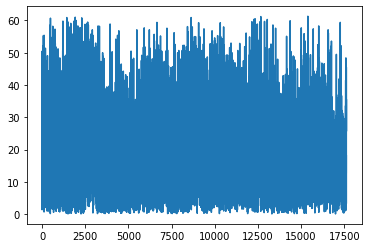

0

In [20]:
# SAT&ACT participation aggregate percent value

sat_data = school_data.iloc[: , 679:698]
test_participation = school_data['TOT_SATACT_M'] + school_data['TOT_SATACT_F']
school_population = school_data['TOT_ENR_M'] + school_data['TOT_ENR_F']
test_pop_percents = round(test_participation / school_population, 3) * 100
plt.plot(test_pop_percents)
plt.show()
len(test_pop_percents[test_pop_percents>100])

## Columns we're filtering

we are aggregating a number of columns due to the columns being separated by reported biological sex, which we are not studying currently.

In [21]:
'''
    SOME INTERESTING DATA COLUMNS THAT ONE MIGHT WANT TO SUPPLIMENT THE AUTOMATICALLY GENERATED ONES WITH:

    # $/student = salary expenditures for total personel
    #           + non personnel expenditures with activities
    #           / overall reported male pop + female pop
    school_input_factors['FUNDING_PER_STUDENT']=(school_data.SCH_SAL_TOTPERS_WFED+school_data.SCH_NPE_WFED) / (school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # Hispanic Demographic percent enrollment = hispanic Male 
    #                                         + hispanic Female 
    #                                         / (overall reported male pop + female pop)
    school_input_factors['PERCENT_ENR_HI'] = (school_data.SCH_ENR_HI_M+school_data.SCH_ENR_HI_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # Above but population information for American Indian / Alaska Native individuals
    school_input_factors['PERCENT_ENR_AM'] = (school_data.SCH_ENR_AM_M+school_data.SCH_ENR_AM_F+  school_data.SCH_ENR_HP_M+school_data.SCH_ENR_HP_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # Above but population information for Asian individuals
    school_input_factors['PERCENT_ENR_AS'] = (school_data.SCH_ENR_AS_M+school_data.SCH_ENR_AS_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # Above but population information for Black individuals
    school_input_factors['PERCENT_ENR_BL'] = (school_data.SCH_ENR_BL_M+school_data.SCH_ENR_BL_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # Above but population information for white individuals
    school_input_factors['PERCENT_ENR_WH'] = (school_data.SCH_ENR_WH_M+school_data.SCH_ENR_WH_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # Above but population information for "two or more races" individuals
    school_input_factors['PERCENT_ENR_TR'] = (school_data.SCH_ENR_TR_M+school_data.SCH_ENR_TR_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # instances of corporal punishment = punishment of individuals without disabilities
    #                                  + punishment of individuals with disabilities
    #                                  / total population of school
    school_input_factors['CORP_PUNISH'] = (school_data.SCH_CORPINSTANCES_WODIS+school_data.SCH_CORPINSTANCES_WDIS)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # Total population of school = reported male pop and female pop
    #  (problematic but that adds up to 100% in this dataset)
    school_input_factors['SCH_SIZE'] = (school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # suspensions percent = suspencions of individuals w/ disabilities
    #                     + suspencions of individuals w/o disabilities
    school_input_factors['SUSPENSION'] = (school_data.SCH_OOSINSTANCES_WODIS+school_data.SCH_OOSINSTANCES_IDEA+school_data.SCH_OOSINSTANCES_504)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # expulsions = num of male students w/o disabilities who receives expulsions
    #            + num of female students w/o disabilities who receives expulsions
    #            + num of limited english proficient male students w/o disabilities who receives expulsions
    #            + num of limited english proficient female students w/o disabilities who receives expulsions
    school_input_factors['EXPULSIONS'] = (school_data.TOT_DISCWODIS_EXPZT_M+school_data.TOT_DISCWODIS_EXPZT_F+school_data.SCH_DISCWODIS_EXPZT_LEP_M+school_data.SCH_DISCWODIS_EXPZT_LEP_F
    )/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)

    # retensions = Total number of students retained in grade 9: Calculated Male Total
    #            + Total number of students retained in grade 9: Calculated Female Total
    #            + Total number of students retained in grade 10: Calculated Male Total
    #            + Total number of students retained in grade 10: Calculated Female Total
    #            + Total number of students retained in grade 11: Calculated Male Total
    #            + Total number of students retained in grade 11: Calculated Female Total
    #            + Total number of students retained in grade 12: Calculated Male Total
    #            + Total number of students retained in grade 12: Calculated Female Total
    school_input_factors['RETENSION'] = school_data.TOT_RET_G09_M+school_data.TOT_RET_G09_F+school_data.TOT_RET_G10_M+school_data.TOT_RET_G10_F+school_data.TOT_RET_G11_M+school_data.TOT_RET_G11_F+school_data.TOT_RET_G12_M+school_data.TOT_RET_G12_F
    school_input_factors.RETENSION[school_input_factors.RETENSION<0] = 0

    # whether school is a charter school or not 
    school_input_factors['CHARTER'] = school_data.SCH_STATUS_CHARTER.eq('Yes').mul(1)
    school_input_factors.CORP_PUNISH[school_input_factors.CORP_PUNISH<0] = 0

    # limited english proficiency = Enrollment of Male Students who are Limited English Proficient
    #                             + Enrollment of Female Students who are Limited English Proficient
    #                             / total school pop
    school_input_factors['ENG_PROF'] = (school_data.TOT_LEPENR_M+school_data.TOT_LEPENR_F)/(school_data.TOT_ENR_M + school_data.TOT_ENR_F)
''';


In [22]:
#FINDING FULLY POPULATED FIELDS THAT ARE NUMERICAL IN NATURE
nul_vals = [-2,-5,-6,-7,-8,-9, '-2', '-5', '-6','-7','-8','-9']
rates = []
rates_full = []
for (columnName, columnData) in school_data.iteritems():
    error_rate = round(len(school_data[columnName][school_data[columnName].isin(nul_vals)])/school_data.shape[0], 3)
    column_name = columnName
    rates.append(error_rate)
    rates_full.append([error_rate, column_name])
    #print(error_rate, column_name)
input_columns = []
for [perc, name] in rates_full:
    if perc == 0:
        if school_data[name].dtype == 'int64':
            input_columns.append(name)
            
print(len(input_columns))

school_input_factors = school_data[input_columns]

#REMOVE ALL NON-TOTAL COLUMNS TO PREVENT REDUNDANCY
totals = [s for s in input_columns if "TOT" not in s]

#TAKE OUT VARIABLES THAT WILL BE USED FOR THE "SUCCESS" METRIC
SAT_things = [s for s in input_columns if "SATACT" in s]

#TAKE OUT DISCIPLINARY ACTION IN PERSONS WITH DISABILITIES
DIS_things = [s for s in input_columns if "WDIS" in s]

#COMBINE ALL COLUMNS TO REMOVE FROM DATA INPUT
bad_things = SAT_things+totals+['SCHID']+DIS_things
school_input_factors.drop(bad_things,axis=1,inplace = True)

#ADD IN ANY HAND-CRAFTED FACTORS
school_input_factors['FUNDING_PER_STUDENT']=(school_data.SCH_SAL_TOTPERS_WFED+school_data.SCH_NPE_WFED) / (school_data.TOT_ENR_M + school_data.TOT_ENR_F)

good_fund_data_high = school_input_factors.FUNDING_PER_STUDENT.index[(school_input_factors.FUNDING_PER_STUDENT<(1.5*school_input_factors.FUNDING_PER_STUDENT.quantile(.95)))].tolist()
good_fund_data_low = school_input_factors.FUNDING_PER_STUDENT.index[(school_input_factors.FUNDING_PER_STUDENT>(.5*school_input_factors.FUNDING_PER_STUDENT.quantile(.05)))].tolist()
good_fund_data = list(set(good_fund_data_high) & set(good_fund_data_low))

school_input_factors = school_input_factors.ix[good_fund_data]
test_pop_percents = test_pop_percents.ix[good_fund_data]


457


/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.7/site-packages

## Regression Setup

These are helper functions for running and testing linear regressions.

In [23]:
def linear_regression(X, y):
    w, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
    return w

In [24]:
def fit_model(dfx, dfy):
    # Prints test and train accuracy from linear regression model
    X_train, X_test, y_train, y_test = \
        train_test_split(dfx, dfy) 
    # Split may be biased because points are close together in time

    model = LinearRegression()
    model.fit(X_train, y_train)
    # I commented out print lines because I already evaluated co-efficients
    #for i, c in enumerate(cols):
    #  print('w_%d (the weight for %s) = %f' % (i+1, c, model.coef_[i])) #coeffs
    #print('w_%d (the weight for the bias term) = %f' % (len(cols) + 1, model.intercept_)) #bias

    # Because y is not binary, I use a 2% margin of error to value correctness of prediction
    print('Accuracy on training set', (abs(model.predict(X_train) - y_train)<10).mean())
    print('Accuracy on testing set', (abs(model.predict(X_test) - y_test)<10).mean())
    return model

## Regression of School Success based on SAT/ACT Participation

Based on the previously filtered columns, construct a model for sat/act participation. We are using that as a success metric because it is fully populated in the data, and when looking at the columns, it exposes several interesting biases in the datset

In [25]:
# X_education = revs_total_1992.drop(columns=['STATE', 'AVG_MATH_8_SCORE'])
# y_education = revs_total_1992['AVG_MATH_8_SCORE']

# The columns we are inputting (the input)
X_experimental = school_input_factors #change assignent here

# The column(s) we are predicting (the output)
Y_experimental = test_pop_percents #change assignent here

Initial weight outputs

In [26]:
X_experimental['bias'] = 1
# display the outputed weights to the input columns so that we can look
# at the calculated correlations relative to each input.
model_output = list(zip(linear_regression(X_experimental, Y_experimental), X_experimental.columns))
pp = pprint.PrettyPrinter(indent=4)
print('RAW MODEL WEIGHT OUTPUTS')
pp.pprint(model_output)

RAW MODEL WEIGHT OUTPUTS
[   (0.005213537230456752, 'TOT_ENR_M'),
    (-0.0057574861924980895, 'TOT_ENR_F'),
    (-0.03600686165401435, 'TOT_LEPENR_M'),
    (0.036959132551775895, 'TOT_LEPENR_F'),
    (0.011482543951127994, 'TOT_LEPPROGENR_M'),
    (-0.030997672844100987, 'TOT_LEPPROGENR_F'),
    (-0.0046616333922615966, 'TOT_504ENR_M'),
    (0.03970692949839157, 'TOT_504ENR_F'),
    (0.02180781192604809, 'TOT_DISCWODIS_ISS_M'),
    (-0.016557382088741968, 'TOT_DISCWODIS_ISS_F'),
    (0.0040573709107978645, 'TOT_DISCWODIS_SINGOOS_M'),
    (0.03178816202547675, 'TOT_DISCWODIS_SINGOOS_F'),
    (-0.06084861162663319, 'TOT_DISCWODIS_MULTOOS_M'),
    (0.032952242451090435, 'TOT_DISCWODIS_MULTOOS_F'),
    (0.0001564269775267784, 'TOT_DAYSMISSED_M'),
    (-0.0013309928576552197, 'TOT_DAYSMISSED_F'),
    (-0.019026715213367608, 'TOT_DISCWODIS_EXPWE_M'),
    (0.07301838531719357, 'TOT_DISCWODIS_EXPWE_F'),
    (0.01021033290022465, 'TOT_DISCWODIS_EXPWOE_M'),
    (-0.0817224663223051, 'TOT_DISCWO

# Visualization of Distribution of Points
Having seen the weights output by our system model, let's take a closer look at the distributions of points

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


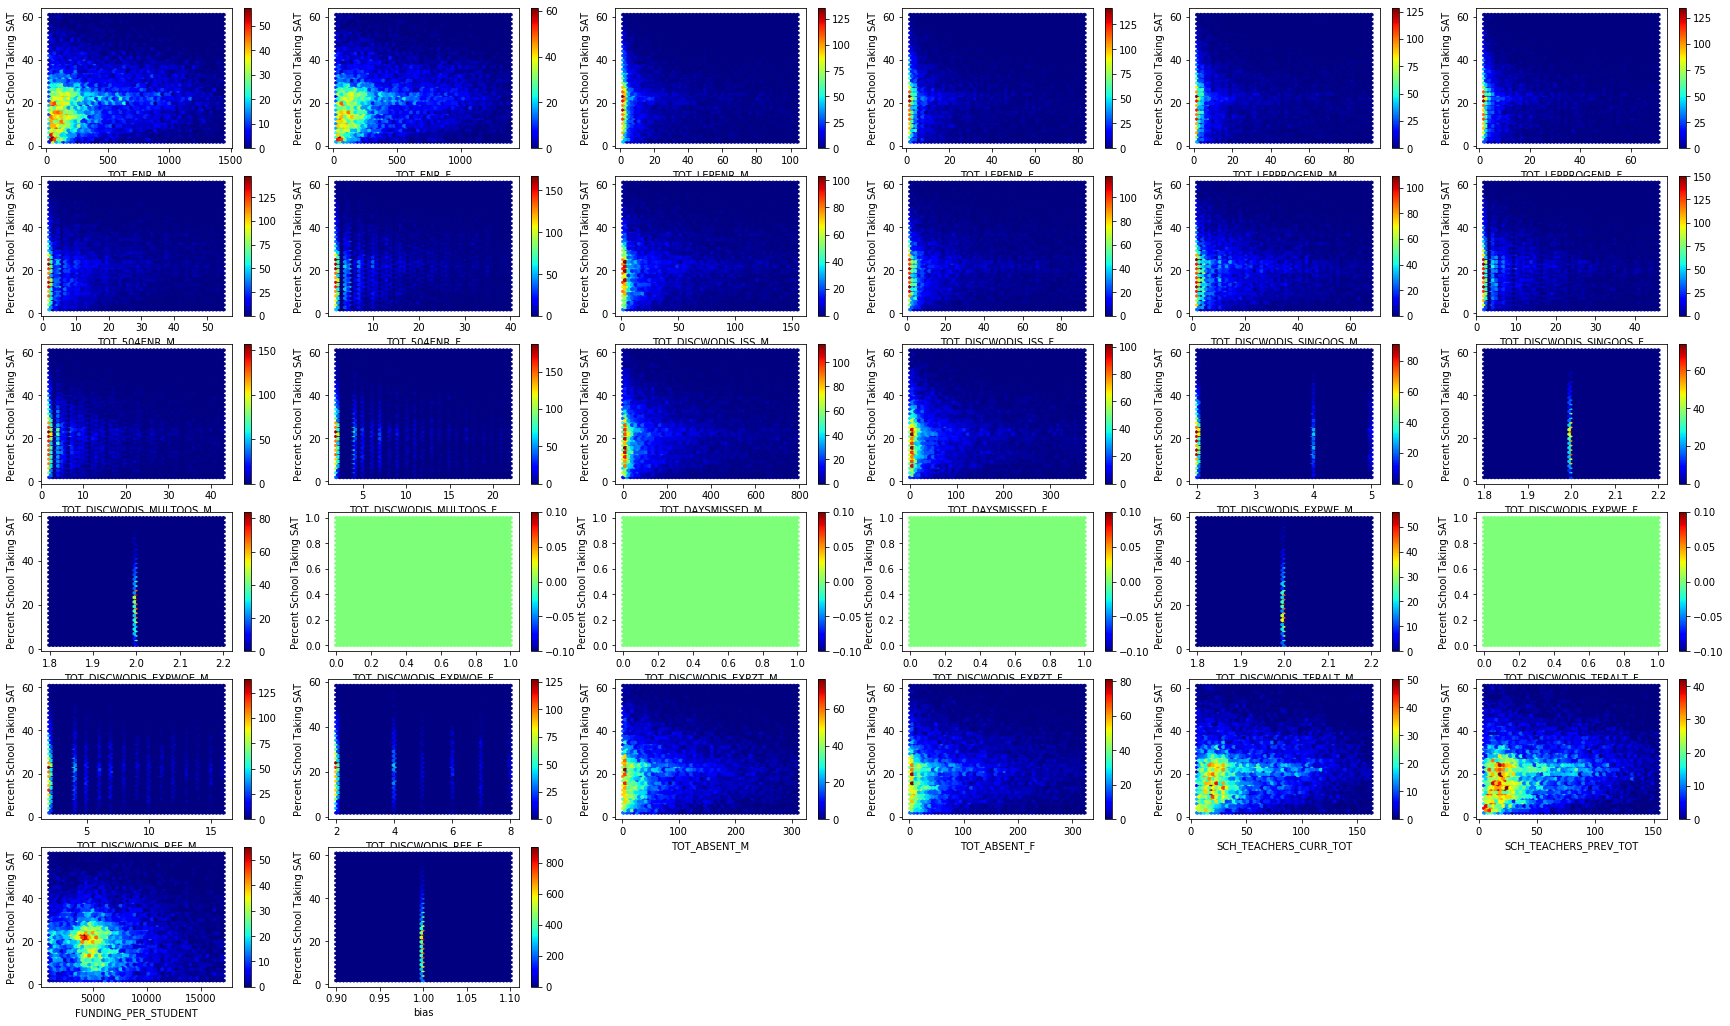

In [27]:
x_ed = X_experimental
y_ed = Y_experimental


plt.figure(figsize=(30, 18))
for idx, col in enumerate(x_ed):
    good_data_1 = x_ed[col].index[(x_ed[col]<(1.5*x_ed[col].quantile(.9)))].tolist()
    good_data_0 = x_ed[col].index[(x_ed[col]>(.5*x_ed[col].quantile(.1)))].tolist()
    good_data_eh = list(set(good_data_1) & set(good_data_0))
    
    good_data_3 = y_ed.index[(y_ed<(1.5*y_ed.quantile(.95)))].tolist()
    good_data_4 = y_ed.index[(y_ed>(.5*y_ed.quantile(.05)))].tolist()
    good_data_almost = list(set(good_data_3) & set(good_data_4))
    
    good_var_data = list(set(good_data_eh) & set(good_data_almost))
    
    # TO MAKE SINGLE COMBINATIONAL PLOT COMMENT PREVIOUS LINE AND UNCOMMENT THE FOLLOWING:
    #good_data_5 = x_ed[col1].index[(x_ed[col1]<(1.5*x_ed[col1].quantile(.9)))].tolist()
    #good_data_6 = x_ed[col1].index[(x_ed[col1]>(.5*x_ed[col1].quantile(.1)))].tolist()
    #good_data_meh = list(set(good_data_5) & set(good_data_6))
    #good_data = list(set(good_data_eh) & set(good_data_almost) & set(good_data_meh))
    #plt.hexbin(x_ed[col].iloc[good_data]+x_ed[col1].iloc[good_data], y_ed.iloc[good_data], gridsize=50, cmap='jet')
    
    sub_dim = np.ceil(len(x_ed.columns)/6)
    plt.subplot(6, sub_dim, idx+1)
    plt.hexbin(x_ed[col].ix[good_var_data], y_ed.ix[good_var_data], gridsize=50, cmap='jet')
    plt.colorbar()
    plt.xlabel(col,fontsize=10)
    plt.ylabel('Percent School Taking SAT',fontsize=10)
    

plt.tick_params(axis='both', which='major', labelsize=10)
plt.subplots_adjust(wspace=.2)
plt.savefig('firstrun.png', transparent=True) # save the figure
plt.show()


For an even closer look, we look at the SAT/ACT versus school size and see how the points are distributed.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


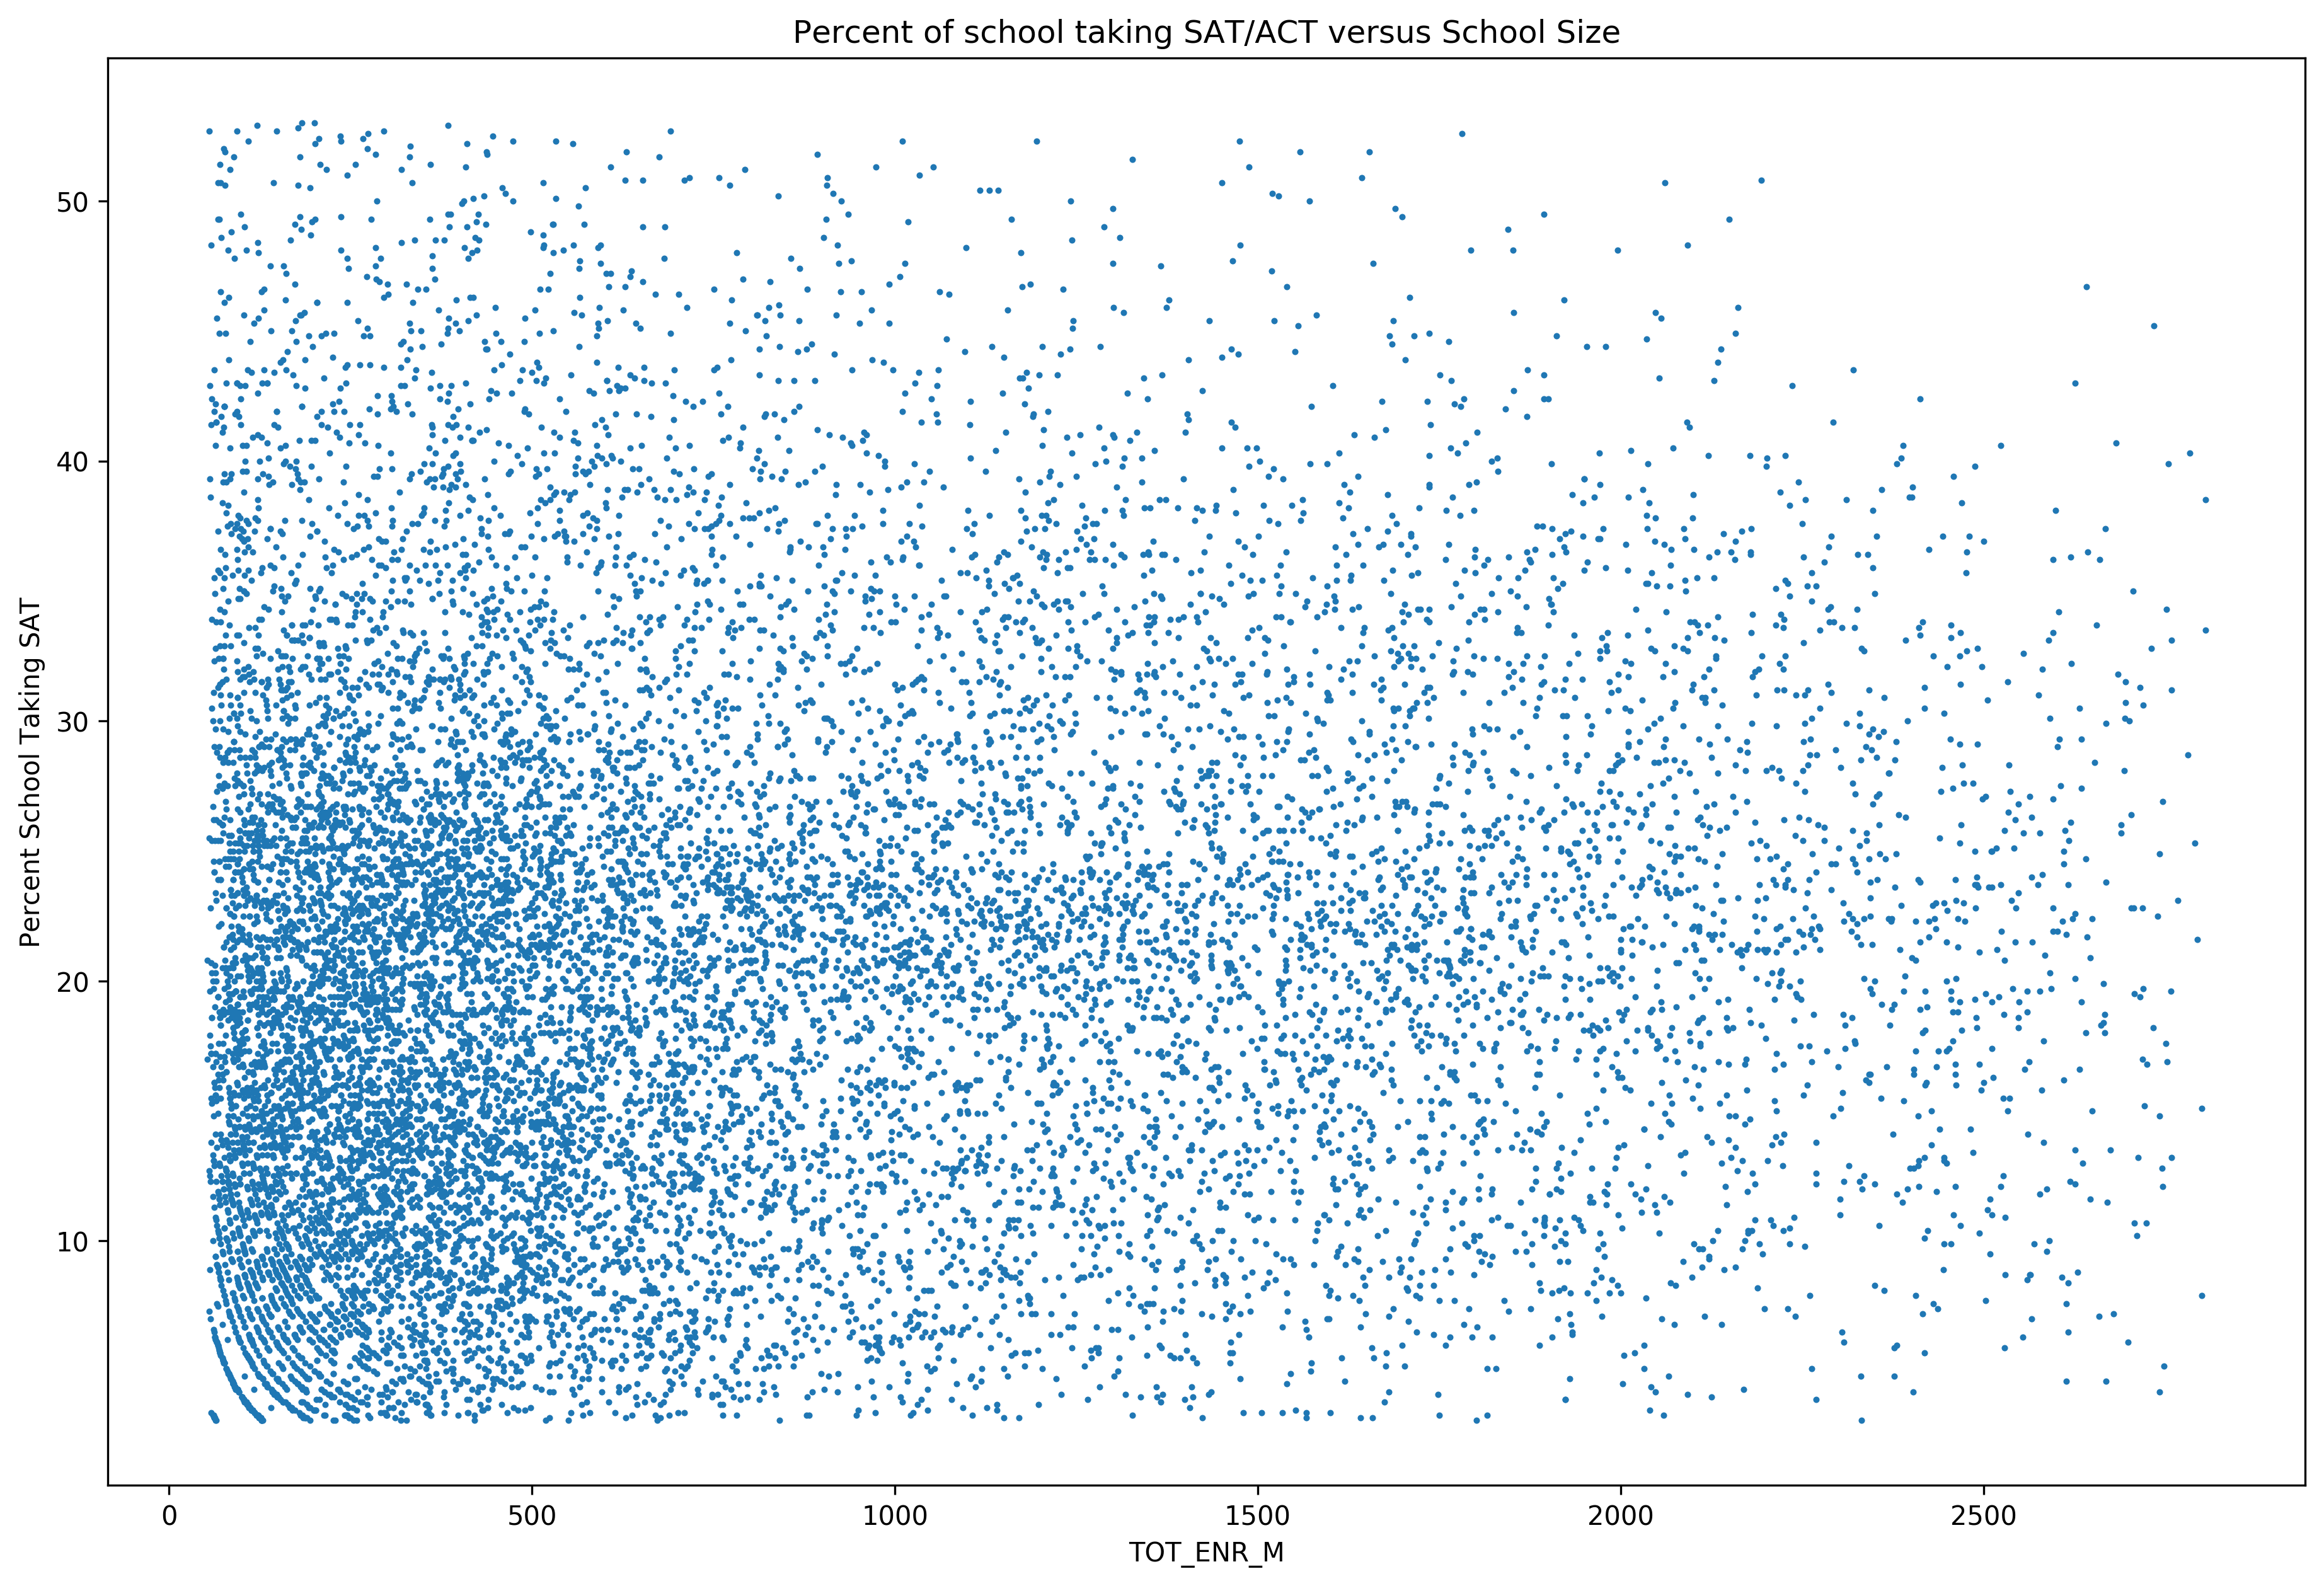

In [28]:
plt.figure(figsize=(15, 10),dpi=300)

col = 'TOT_ENR_M'
col1 = 'TOT_ENR_F'
good_data_1 = x_ed[col].index[(x_ed[col]<(1.5*x_ed[col].quantile(.9)))].tolist()
good_data_0 = x_ed[col].index[(x_ed[col]>(.5*x_ed[col].quantile(.1)))].tolist()
good_data_eh = list(set(good_data_1) & set(good_data_0))

good_data_3 = y_ed.index[(y_ed<(1.5*y_ed.quantile(.9)))].tolist()
good_data_4 = y_ed.index[(y_ed>(.5*y_ed.quantile(.1)))].tolist()
good_data_almost = list(set(good_data_3) & set(good_data_4))
    
good_data_5 = x_ed[col1].index[(x_ed[col1]<(1.5*x_ed[col1].quantile(.9)))].tolist()
good_data_6 = x_ed[col1].index[(x_ed[col1]>(.5*x_ed[col1].quantile(.1)))].tolist()
good_data_meh = list(set(good_data_5) & set(good_data_6))
good_data = list(set(good_data_eh) & set(good_data_almost) & set(good_data_meh))

plt.scatter(x_ed[col1].ix[good_data]+x_ed[col].ix[good_data],y_ed.ix[good_data], s=2)
plt.xlabel("TOT_ENR_M")
plt.ylabel('Percent School Taking SAT')
plt.title("Percent of school taking SAT/ACT versus School Size")
plt.savefig('size_dist.png', transparent=True) # save the figure

What are the mins and maxes of each column? (i.e how what is the largest and smallest unique value in each column)

In [29]:
for idx, col in enumerate(x_ed):
    print(col, min(x_ed[col].unique()))
    print(col, max(x_ed[col].unique()), "\n")
#school_data[X_experimental.FUNDING_PER_STUDENT == min(X_experimental.FUNDING_PER_STUDENT.unique())]

TOT_ENR_M 0
TOT_ENR_M 6713 

TOT_ENR_F 0
TOT_ENR_F 7733 

TOT_LEPENR_M 0
TOT_LEPENR_M 1683 

TOT_LEPENR_F 0
TOT_LEPENR_F 1479 

TOT_LEPPROGENR_M 0
TOT_LEPPROGENR_M 1758 

TOT_LEPPROGENR_F 0
TOT_LEPPROGENR_F 1605 

TOT_504ENR_M 0
TOT_504ENR_M 246 

TOT_504ENR_F 0
TOT_504ENR_F 199 

TOT_DISCWODIS_ISS_M 0
TOT_DISCWODIS_ISS_M 843 

TOT_DISCWODIS_ISS_F 0
TOT_DISCWODIS_ISS_F 713 

TOT_DISCWODIS_SINGOOS_M 0
TOT_DISCWODIS_SINGOOS_M 487 

TOT_DISCWODIS_SINGOOS_F 0
TOT_DISCWODIS_SINGOOS_F 306 

TOT_DISCWODIS_MULTOOS_M 0
TOT_DISCWODIS_MULTOOS_M 486 

TOT_DISCWODIS_MULTOOS_F 0
TOT_DISCWODIS_MULTOOS_F 283 

TOT_DAYSMISSED_M -5
TOT_DAYSMISSED_M 5974 

TOT_DAYSMISSED_F -5
TOT_DAYSMISSED_F 4385 

TOT_DISCWODIS_EXPWE_M 0
TOT_DISCWODIS_EXPWE_M 320 

TOT_DISCWODIS_EXPWE_F 0
TOT_DISCWODIS_EXPWE_F 266 

TOT_DISCWODIS_EXPWOE_M 0
TOT_DISCWODIS_EXPWOE_M 320 

TOT_DISCWODIS_EXPWOE_F 0
TOT_DISCWODIS_EXPWOE_F 266 

TOT_DISCWODIS_EXPZT_M 0
TOT_DISCWODIS_EXPZT_M 320 

TOT_DISCWODIS_EXPZT_F 0
TOT_DISCWODIS_EXPZT_F 

Finally, let's check the accuracy of this model using a new training 

In [30]:
#X_cols defines x variables for run, and then I run the train/test linear regression model
fit_model(x_ed, y_ed);

Accuracy on training set 0.6354166666666666
Accuracy on testing set 0.6321893491124261


# Breaking Down the Weights
In order to understand the weights of the system, we must understand how they contribute to the output of the model. By multiplying the model's output weights by the average of the column, we are able to ascertain the percentage that each factor contributes to the output.

In [31]:
norm_weights = []
average_SAT=0
for val, col in model_output:
    norm_weights.append([col, val*x_ed[col].mean()])
    average_SAT = average_SAT+val
mean_weights = sorted((norm_weights), key = lambda x: x[1])

percent_weights = [[s[0],s[1]/average_SAT] for s in mean_weights]
pp = pprint.PrettyPrinter(indent=4)
print('CONTRIBUTIONS TO THE FINAL VALUE FROM THE ALGORITHM:')
pp.pprint(percent_weights)

CONTRIBUTIONS TO THE FINAL VALUE FROM THE ALGORITHM:
[   ['TOT_ABSENT_M', -0.1737382385963242],
    ['TOT_ENR_F', -0.11906134945095663],
    ['TOT_LEPENR_M', -0.04670297936462145],
    ['TOT_DISCWODIS_MULTOOS_M', -0.03320866076449123],
    ['FUNDING_PER_STUDENT', -0.029492629706435396],
    ['TOT_LEPPROGENR_F', -0.027475509034583734],
    ['SCH_TEACHERS_CURR_TOT', -0.018819587830085492],
    ['TOT_DISCWODIS_ISS_F', -0.017865313049396606],
    ['TOT_DAYSMISSED_F', -0.006472652051395322],
    ['TOT_504ENR_M', -0.0033239836964582274],
    ['TOT_DISCWODIS_EXPWE_M', -0.001370352491146639],
    ['TOT_DISCWODIS_TFRALT_M', -0.0012194237614531341],
    ['TOT_DISCWODIS_EXPWOE_F', -0.0010838751605821003],
    ['TOT_DISCWODIS_EXPZT_F', -0.0008725084883442547],
    ['TOT_DISCWODIS_EXPWOE_M', 0.0003132904210779289],
    ['TOT_DISCWODIS_REF_F', 0.001218562308088403],
    ['TOT_DISCWODIS_TFRALT_F', 0.001345345564407602],
    ['TOT_DISCWODIS_EXPZT_M', 0.0015343492757709351],
    ['TOT_DAYSMISSED_M', 0.

# School Specific Look-up
Using this interactive tool, users can view statistics about their school and understand on a more personal level the significance of the gross inequities of punishments, in particular suspensions in their community and across the United States.

In [32]:
def percentage_of_students(school_layout, school_data,layout_a_start,layout_a_stop):
    enrollment = []
    np.seterr(divide = 'ignore')
    enroll_categories = range(layout_a_start,layout_a_stop+1,1)
    enrollment_vals = np.empty([len(enroll_categories)*len(school_data)])
    enrollment_vals.shape = [len(enroll_categories),len(school_data)]
    for i in range(len(enroll_categories)):
        j = enroll_categories[i]
        #print(school_layout['Field_Description'][school_layout['Order']==j].values[0])
        enrollment.append(str(school_layout['Field_Name'][school_layout['Order']==j].values[0]))
        nul_bool = school_data[enrollment[-1]].isin(nul_vals)
        value = np.array(school_data[enrollment[-1]])
        value[nul_bool] = 0
        if i == 0:
            enrollment_vals[0] = value
        else:
            enrollment_vals[i] = value
    return(enrollment_vals)

race_sex_breakdown_order = ['Hispanic Male','Hispanic Female','American Indian/Alaska Native Male','American Indian/Alaska Native Female','Asian Male','Asian Female','Native Hawaiian/Pacific Islander Male','Native Hawaiian/Pacific Islander Female','Black Male','Black Female','White Male','White Female','Two or More Races Male','Two or More Races Female','Calculated Male Total','Calculated Female Total']


enrollment = percentage_of_students(school_layout,school_dat,56,71)
suspensions = percentage_of_students(school_layout,school_dat,822,837)
print(len(enrollment),len(suspensions))
suspensions = np.array(suspensions, dtype=float)
percentages = suspensions/enrollment
percentages = np.nan_to_num(percentages)
mean_susp = np.round(np.mean(suspensions,axis=1),3)
mean_enroll = np.round(np.mean(enrollment,axis=1),3)
mean_perc_susp_per_enroll = 100*np.round(np.mean(suspensions,axis=1)/np.mean(enrollment,axis=1),3)

print('\n\nAVERAGE NUMBER OF STUDENTS SUSPENDED:\n')
pp.pprint([[np.round(mean_susp[s],1),race_sex_breakdown_order[s]] for s in range(len(mean_susp))])
print('\n\nAVERAGE NUMBER OF STUDENTS IN AN AVERAGE SCHOOL:\n')
pp.pprint([[np.round(mean_enroll[s],1),race_sex_breakdown_order[s]] for s in range(len(mean_enroll))])
print('\n\nAVERAGE PERCENTAGE OF STUDENTS SUSPENDED IN AN AVERAGE SCHOOL:\n')
pp.pprint([[np.round(mean_perc_susp_per_enroll[s],2),race_sex_breakdown_order[s]] for s in range(len(mean_perc_susp_per_enroll))])

16 16


AVERAGE NUMBER OF STUDENTS SUSPENDED:

[   [2.0, 'Hispanic Male'],
    [1.0, 'Hispanic Female'],
    [0.1, 'American Indian/Alaska Native Male'],
    [0.1, 'American Indian/Alaska Native Female'],
    [0.2, 'Asian Male'],
    [0.1, 'Asian Female'],
    [0.0, 'Native Hawaiian/Pacific Islander Male'],
    [0.0, 'Native Hawaiian/Pacific Islander Female'],
    [2.9, 'Black Male'],
    [2.0, 'Black Female'],
    [3.0, 'White Male'],
    [1.2, 'White Female'],
    [0.4, 'Two or More Races Male'],
    [0.2, 'Two or More Races Female'],
    [8.7, 'Calculated Male Total'],
    [4.6, 'Calculated Female Total']]


AVERAGE NUMBER OF STUDENTS IN AN AVERAGE SCHOOL:

[   [69.3, 'Hispanic Male'],
    [65.9, 'Hispanic Female'],
    [3.0, 'American Indian/Alaska Native Male'],
    [2.8, 'American Indian/Alaska Native Female'],
    [13.3, 'Asian Male'],
    [12.8, 'Asian Female'],
    [1.2, 'Native Hawaiian/Pacific Islander Male'],
    [1.1, 'Native Hawaiian/Pacific Islander Female'],
    [41.4, 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [33]:
#ASK FOR USER INPUT
school_name_part = input('Please Type Some of The Name of Your School:')
your_school = school_dat[school_dat['SCH_NAME'].str.contains(school_name_part)].index
#ASKING FOR MORE SPECIFICITY
YOUR_SCHOOL = -1
while YOUR_SCHOOL == -1:
    if len(your_school) > 1:
        for t in range(len(your_school)):
            left_aligned = str(t)+': '+str(school_dat.SCH_NAME.iloc[your_school].values[t])
            center = school_dat.LEA_STATE_NAME.iloc[your_school].values[t]
            right_aligned = str(school_dat.LEA_NAME.iloc[your_school].values[t])
            print("{1:<40}{0:^25}{2:>50}".format(center, left_aligned, right_aligned))
        school_select = int(input('Please Type the Number Corresponding to Your School: '))
        left_aligned = str(t)+': '+str(school_dat.SCH_NAME.iloc[your_school].values[school_select]);
        center = school_dat.LEA_STATE_NAME.iloc[your_school].values[school_select];
        right_aligned = str(school_dat.LEA_NAME.iloc[your_school].values[school_select]);
        print("{1:<40}{0:^25}{2:>50}".format(center, left_aligned, right_aligned))
        YOUR_SCHOOL = your_school[school_select]
        print(YOUR_SCHOOL)
        print(school_dat['SCH_NAME'].iloc[YOUR_SCHOOL])
    elif len(your_school) == 1:
        right_aligned = school_dat.LEA_STATE_NAME.iloc[your_school].values[0]
        left_aligned = str(school_dat.SCH_NAME.iloc[your_school].values[0])
        center = ' '
        print("{1:<40}{0:^25}{2:>20}".format(center, left_aligned, right_aligned))
        YOUR_SCHOOL = your_school
    else:
        print('Uh Oh. WE COULD NOT FIND YOUR SCHOOL. PLEASE TRY ANOTHER SEARCH WORD.')
        break
your_percentages = np.round(100*percentages[:,YOUR_SCHOOL],1)
print('\n','\n',"{1:<20}{0:^40}{2:>50}".format('Sex/Race Subgroup','% Suspended', 'Number of Enrolled Students'))
print('-------------------------------------------------------------------------------------------------------------')
for index in range(len(your_percentages)):
    center = race_sex_breakdown_order[index];
    left_aligned = str(float(your_percentages[index]));
    right_aligned = str(float(enrollment[:,YOUR_SCHOOL][index]));
    
    print("{1:<20}{0:^40}{2:>50}".format(center, left_aligned, right_aligned))

Please Type Some of The Name of Your School:Gunn
0: Henry M. Gunn High                          CALIFORNIA                                         Palo Alto Unified
1: Bedford (Gunning) Middle School              DELAWARE                                   Colonial School District
2: J H Gunn Elementary                       NORTH CAROLINA                           Charlotte-Mecklenburg Schools
Please Type the Number Corresponding to Your School: 1
2: Bedford (Gunning) Middle School              DELAWARE                                   Colonial School District
18343
Bedford (Gunning) Middle School

 
 % Suspended                    Sex/Race Subgroup                                   Number of Enrolled Students
-------------------------------------------------------------------------------------------------------------
10.0                             Hispanic Male                                                            50.0
4.5                             Hispanic Female           